In [10]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")


In [3]:
data = pd.read_csv('../data/ola_updated.csv')
print(data.head())

   season  weather   temp  humidity  windspeed  casual  registered  count  \
0       3        2   6.66     76.62       9.57       5         128    133   
1       4        3  13.54     55.91       4.01      36         184    220   
2       1        3  29.58     20.97      33.61      34          97    131   
3       3        1   7.40     61.64      15.85       6          47     53   
4       3        4  30.66     98.71      11.47      14         199    213   

   day  month  year                 time  hour  minute  second  
0    1      1  2011  1900-01-01 00:00:00     0       0       0  
1    1      1  2011  1900-01-01 01:00:00     1       0       0  
2    1      1  2011  1900-01-01 02:00:00     2       0       0  
3    1      1  2011  1900-01-01 03:00:00     3       0       0  
4    1      1  2011  1900-01-01 04:00:00     4       0       0  


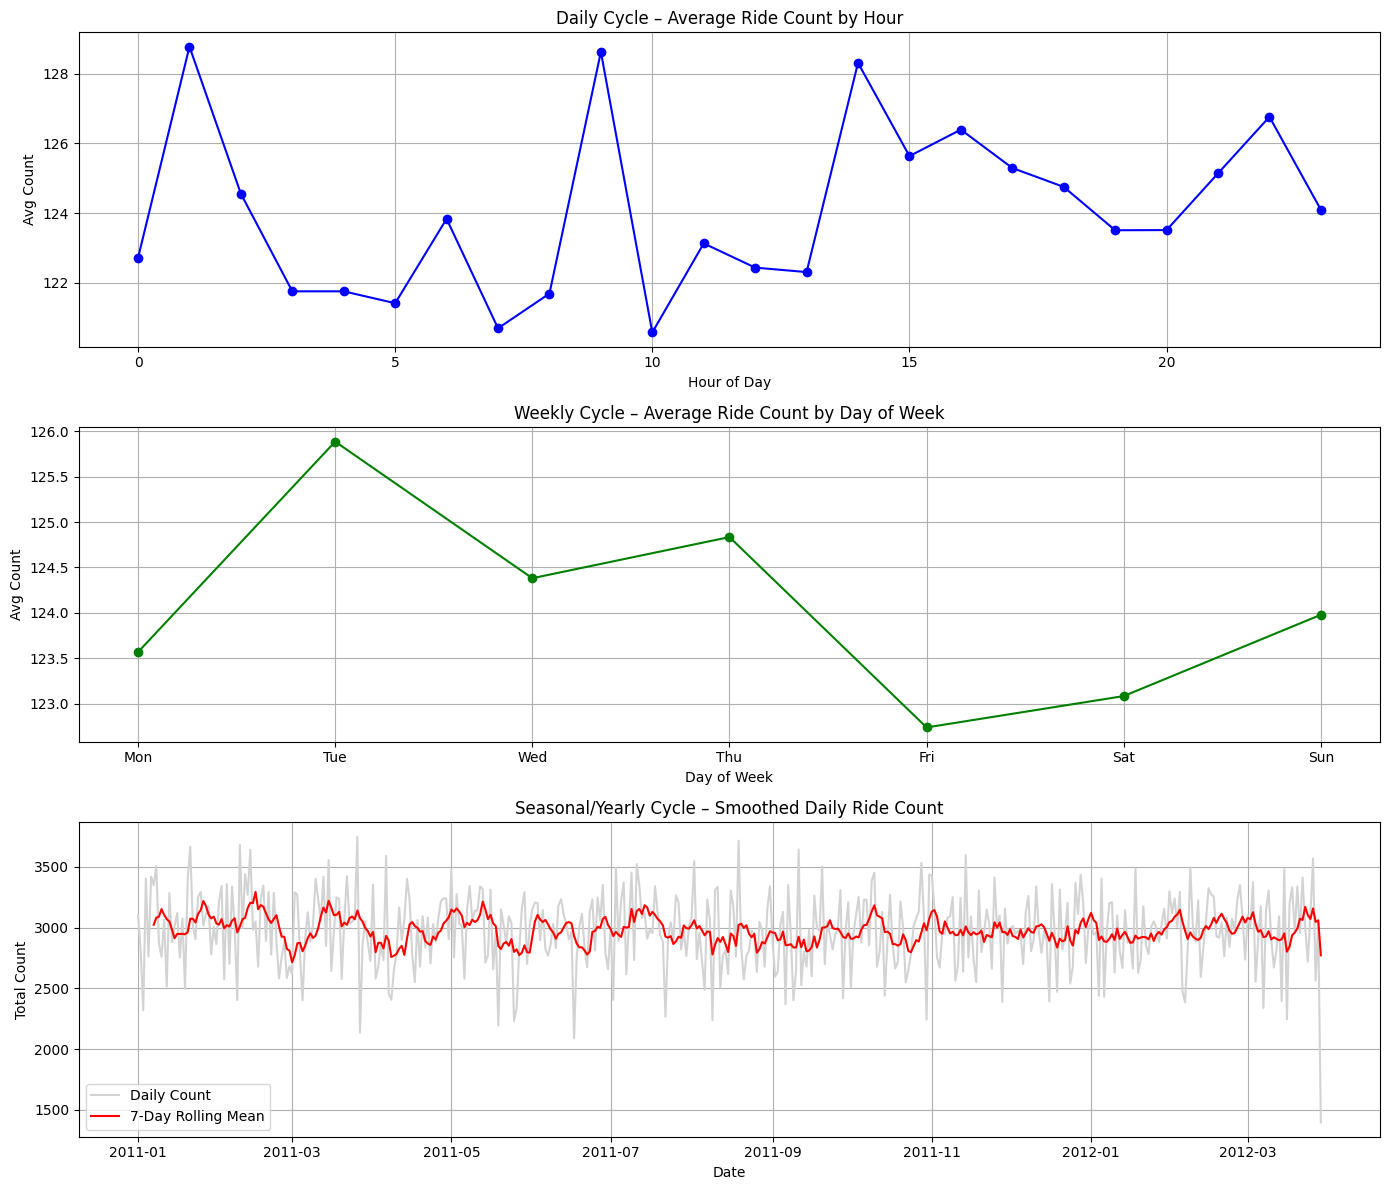

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data['time'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
ts_data = data.set_index('time')


daily_cycle = ts_data.groupby(ts_data.index.hour)['count'].mean()


weekly_cycle = ts_data.groupby(ts_data.index.dayofweek)['count'].mean()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


daily_counts = ts_data['count'].resample('D').sum()
rolling_daily = daily_counts.rolling(window=7).mean()


fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=False)


axs[0].plot(daily_cycle.index, daily_cycle.values, marker='o', color='blue')
axs[0].set_title('Daily Cycle – Average Ride Count by Hour')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Avg Count')
axs[0].grid(True)


axs[1].plot(weekly_cycle.index, weekly_cycle.values, marker='o', color='green')
axs[1].set_title('Weekly Cycle – Average Ride Count by Day of Week')
axs[1].set_xlabel('Day of Week')
axs[1].set_ylabel('Avg Count')
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(weekday_labels)
axs[1].grid(True)


axs[2].plot(daily_counts.index, daily_counts.values, color='lightgray', label='Daily Count')
axs[2].plot(rolling_daily.index, rolling_daily.values, color='red', label='7-Day Rolling Mean')
axs[2].set_title('Seasonal/Yearly Cycle – Smoothed Daily Ride Count')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Total Count')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


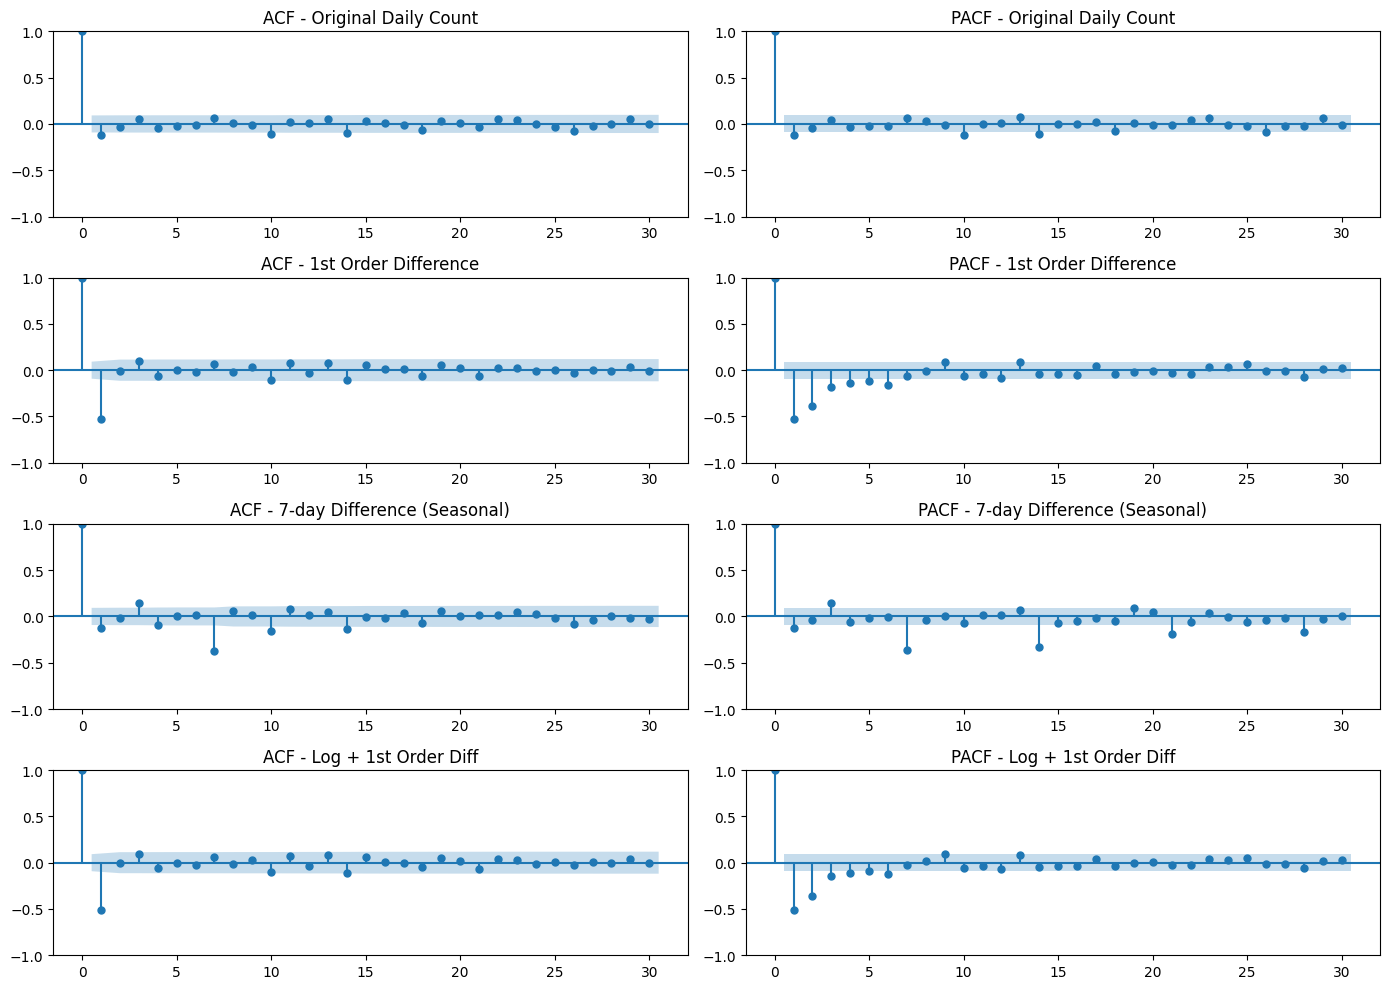

In [9]:
 
daily_counts = ts_data['count'].resample('D').sum().dropna()
diff_1 = daily_counts.diff().dropna()
diff_7 = daily_counts.diff(7).dropna()
log_diff = np.log1p(daily_counts).diff().dropna()

series_list = [
    ('Original Daily Count', daily_counts),
    ('1st Order Difference', diff_1),
    ('7-day Difference (Seasonal)', diff_7),
    ('Log + 1st Order Diff', log_diff)
]

# Plot all in a grid
fig, axs = plt.subplots(len(series_list), 2, figsize=(14, 10))

for i, (title, series) in enumerate(series_list):
    plot_acf(series, lags=30, ax=axs[i, 0])
    axs[i, 0].set_title(f'ACF - {title}')
    plot_pacf(series, lags=30, ax=axs[i, 1])
    axs[i, 1].set_title(f'PACF - {title}')

plt.tight_layout()
plt.show()


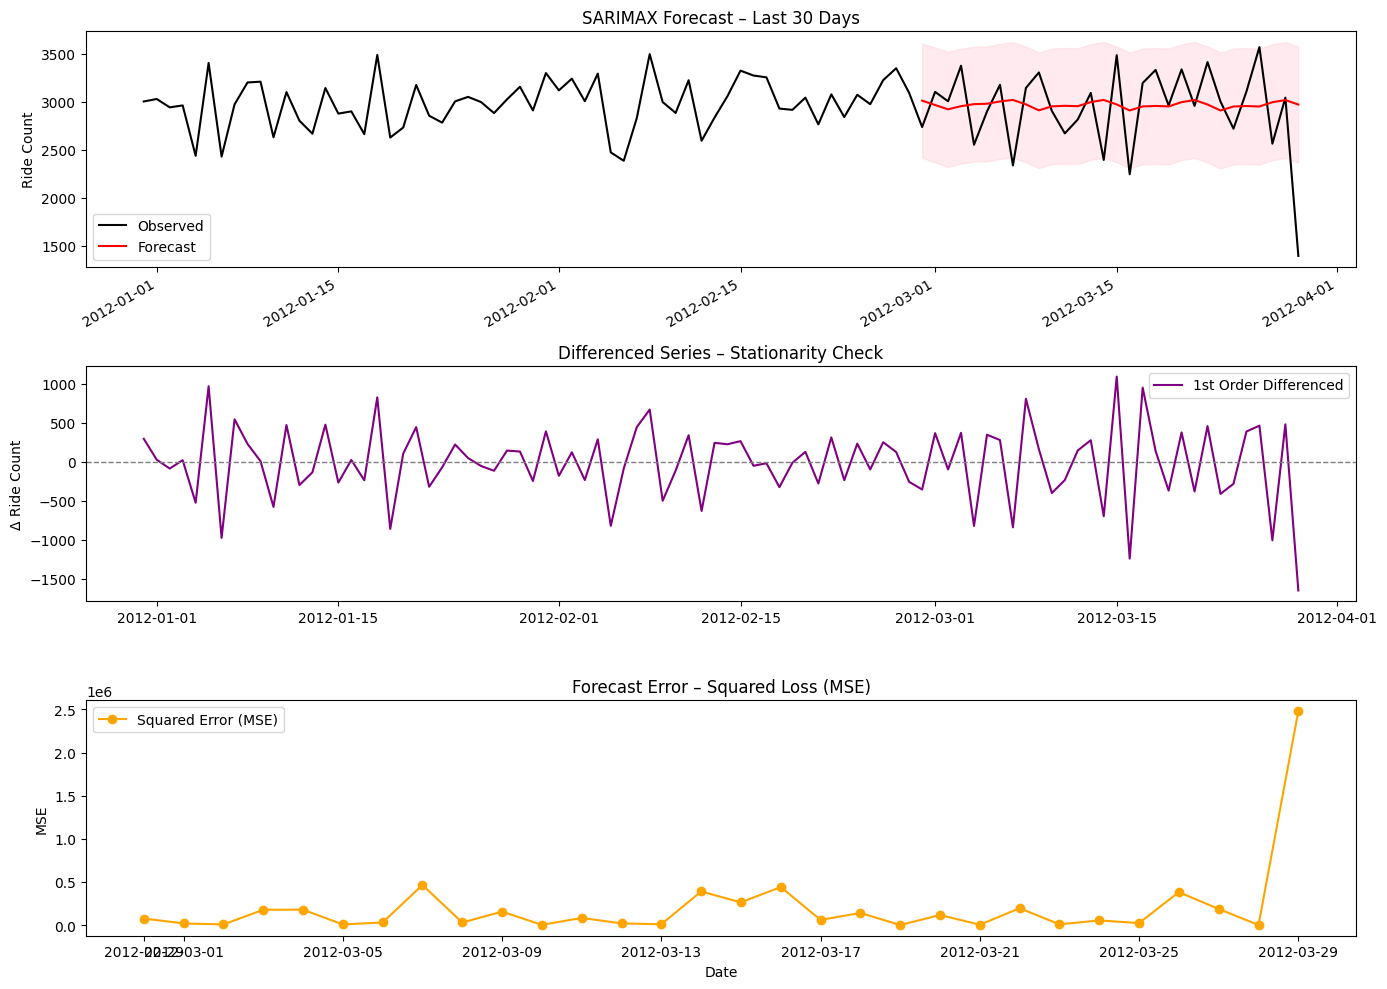

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


daily_counts = ts_data['count'].resample('D').sum().dropna()


train = daily_counts[:-30]
test = daily_counts[-30:]


model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)


forecast = results.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()


mse_loss = (test - forecast_mean)**2


differenced = daily_counts.diff().dropna()


fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)


axes[0].plot(daily_counts[-90:], label='Observed', color='black')
forecast_mean.plot(ax=axes[0], label='Forecast', color='red')
axes[0].fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                     color='pink', alpha=0.3)
axes[0].set_title('SARIMAX Forecast – Last 30 Days')
axes[0].set_ylabel('Ride Count')
axes[0].legend()


axes[1].plot(differenced[-90:], color='purple', label='1st Order Differenced')
axes[1].axhline(0, linestyle='--', color='gray', linewidth=1)
axes[1].set_title('Differenced Series – Stationarity Check')
axes[1].set_ylabel('Δ Ride Count')
axes[1].legend()


axes[2].plot(mse_loss.index, mse_loss.values, color='orange', marker='o', label='Squared Error (MSE)')
axes[2].set_title('Forecast Error – Squared Loss (MSE)')
axes[2].set_ylabel('MSE')
axes[2].set_xlabel('Date')
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller


result_orig = adfuller(daily_counts.dropna())
print('ADF Statistic (Original):', result_orig[0])
print('p-value:', result_orig[1])


diff_1 = daily_counts.diff().dropna()
result_diff1 = adfuller(diff_1)
print('\nADF Statistic (1st Difference):', result_diff1[0])
print('p-value:', result_diff1[1])


diff_seasonal = daily_counts.diff(7).dropna()
result_seasonal = adfuller(diff_seasonal)
print('\nADF Statistic (7-day Seasonal Difference):', result_seasonal[0])
print('p-value:', result_seasonal[1])


ADF Statistic (Original): -23.352548226250452
p-value: 0.0

ADF Statistic (1st Difference): -8.818642925731803
p-value: 1.90373970515759e-14

ADF Statistic (7-day Seasonal Difference): -8.588313402155096
p-value: 7.403021707989803e-14


ADF Statistic (Original): -23.352548226250452
p-value: 0.0

ADF Statistic (1st Difference): -8.818642925731803
p-value: 1.90373970515759e-14

ADF Statistic (7-day Seasonal Difference): -8.588313402155096
p-value: 7.403021707989803e-14


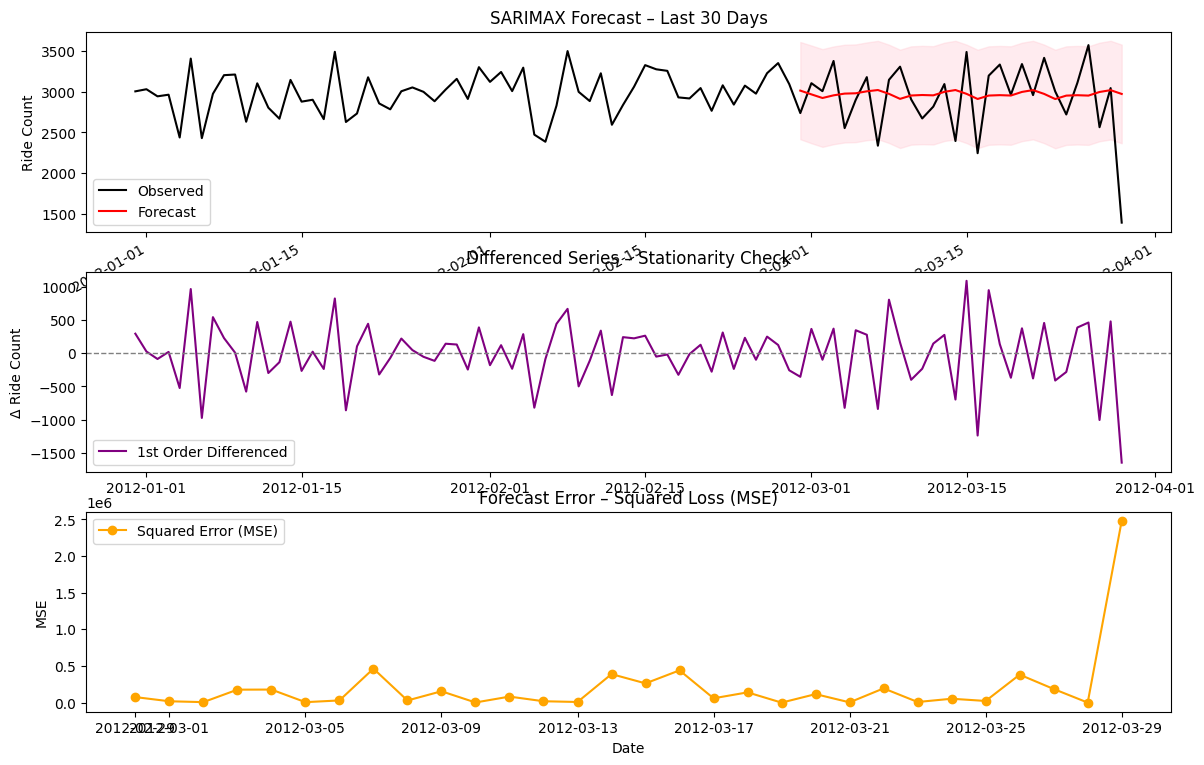

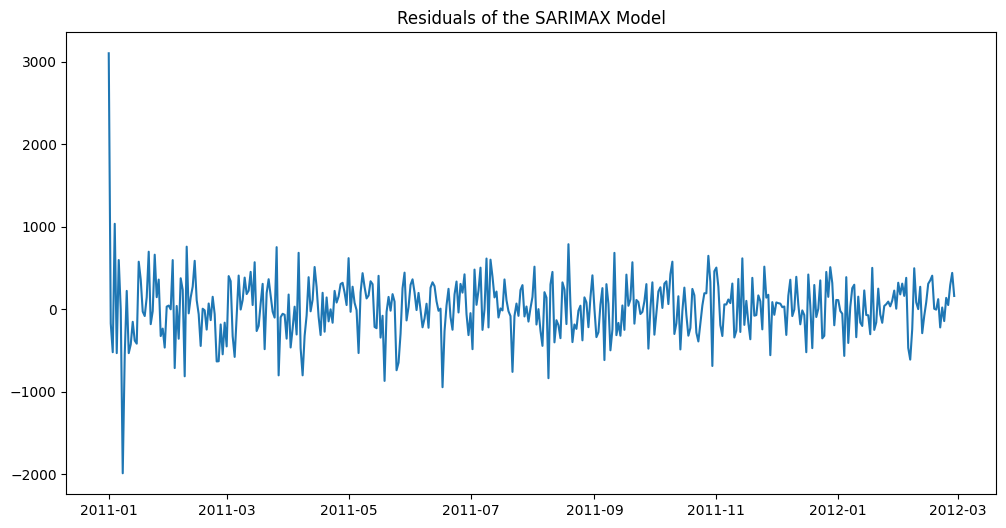

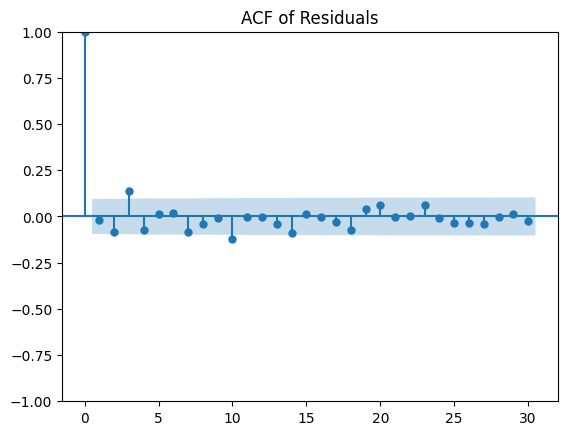

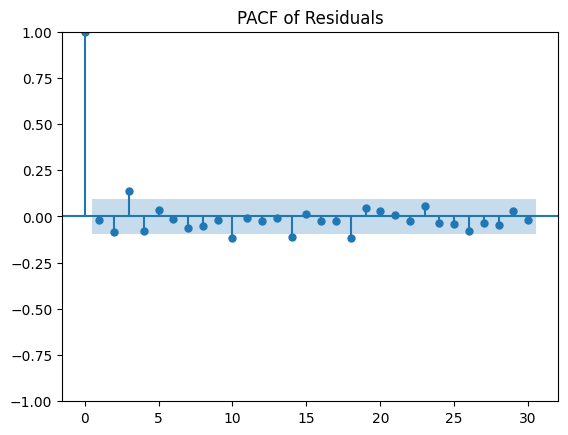

<Figure size 640x480 with 0 Axes>

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns


daily_counts = ts_data['count'].resample('D').sum().dropna()


train = daily_counts[:-30]
test = daily_counts[-30:]


result_orig = adfuller(daily_counts.dropna())
print('ADF Statistic (Original):', result_orig[0])
print('p-value:', result_orig[1])


diff_1 = daily_counts.diff().dropna()
result_diff1 = adfuller(diff_1)
print('\nADF Statistic (1st Difference):', result_diff1[0])
print('p-value:', result_diff1[1])


diff_seasonal = daily_counts.diff(7).dropna()
result_seasonal = adfuller(diff_seasonal)
print('\nADF Statistic (7-day Seasonal Difference):', result_seasonal[0])
print('p-value:', result_seasonal[1])



model = SARIMAX(
    train,
    order=(1, 1, 1),  
    seasonal_order=(1, 1, 1, 7),  
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


forecast = results.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()


mse_loss = (test - forecast_mean)**2


differenced = daily_counts.diff().dropna()


residuals = results.resid



fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)


axes[0].plot(daily_counts[-90:], label='Observed', color='black')
forecast_mean.plot(ax=axes[0], label='Forecast', color='red')
axes[0].fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                     color='pink', alpha=0.3)
axes[0].set_title('SARIMAX Forecast – Last 30 Days')
axes[0].set_ylabel('Ride Count')
axes[0].legend()


axes[1].plot(differenced[-90:], color='purple', label='1st Order Differenced')
axes[1].axhline(0, linestyle='--', color='gray', linewidth=1)
axes[1].set_title('Differenced Series – Stationarity Check')
axes[1].set_ylabel('Δ Ride Count')
axes[1].legend()


axes[2].plot(mse_loss.index, mse_loss.values, color='orange', marker='o', label='Squared Error (MSE)')
axes[2].set_title('Forecast Error – Squared Loss (MSE)')
axes[2].set_ylabel('MSE')
axes[2].set_xlabel('Date')
axes[2].legend()


plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the SARIMAX Model')
plt.show()


plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()

plot_pacf(residuals, lags=30)
plt.title('PACF of Residuals')
plt.show()


plt.tight_layout()
plt.show()
